# Raw Data

Purpose of this notebook is to get the data to suitable
data structure for preprocessing.

The data were taken form antares server. Concretly,
from the `/data/ccd700` directory.

## FITS file format

https://fits.gsfc.nasa.gov/fits_primer.html

Flexible Image Transport System is data format used within
astronomy for transporting, analyzing, archiving scientific
data files. It is design to store data sets consisting of
multidimensiional arrays and two dimensional tables.

In [1]:
import os
import glob
import random
import astropy.io.fits

In [2]:
raw_fits_dir = os.path.join('ondrejov-ccd700', 'raw')
# get path to all files in the dir
raw_fits_filenames = glob.glob(os.path.join(
    raw_fits_dir, '*.fit'
))
# pick random index
random_idx = random.randrange(len(raw_fits_filenames))
raw_fits_filename = raw_fits_filenames[random_idx]

### HDUs

A FITS file is comprised of segmets called Header/Data
Units (HDUs). The first HDU is called the 'Primary HDU'.
The primary data array can contain a 1-999 dimensional
array of numbers. A typical primary array could contain
a 1 dimensional **spectrum**, a 2 dimensional image,
a 3 dimensional data cube.

Any number of additional HDUs may follow the primary array.
These HDUs are referred as 'extensions'. There are three
types of standart extensions currently defined:

1. Image Extension (`XTENSION = 'IMAGE'`)
2. ASCII Table Extension (`XTENSION = 'TABLE'`)
3. Binary Table Extension (`XTENSION = 'BINTABLE'`)

In [3]:
# open file with astropy
raw_hdulist = astropy.io.fits.open(raw_fits_filename)
# display info about the HDUs
raw_hdulist.info()

Filename: ondrejov-ccd700/raw/uh290017.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     143   (1997,)      float32   


HISTORY1                                                                         [astropy.io.fits.card]
HISTORY2                                                                         [astropy.io.fits.card]


### Header Units

Every HDU consists of an ASCII formatted 'Header Unit' and
'Data Unit'.

Each header unit contains a sequence of fixed-length 80
character long keyword record which have form:

    KEYNAME = value / comment string

Non-printing ASCII character such as tabs,
carriage-returns, line-feeds are not allowed anywhere in
the header unit.

In [4]:
# NOTE that sometimes it give error because some FITS
# files have invalid keywords
raw_header = raw_hdulist[0].header
raw_header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                  -32 / Bits per pixel                                 
NAXIS   =                    1 / Number of axes                                 
NAXIS1  =                 1997 / Axis length                                    
EXTEND  =                    F / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '2011-09-19T20:16:19' / Time of last modification                     
OBJECT  = '59 Cyg  '           / Title of observation                           
DATE    = '2011-09-19T20:16:19' / Date FITS file was generated                  
SYSVER  = 'BIAS r151'          / Jul 31 2011 14:57:30                           
OBSERVAT= 'ONDREJOV'           / Name of observatory (IRAF style)               
LATITUDE=            49.910555 / Telescope latitude  (degrees), +49:54:38.0     
LONGITUD=            14.7836

### Data Units

Note that the data unit is not required. The image pixels
in primary array or an image extension may have one of
5 supported data types:

* 8-bit (unsigned) integer bytes
* 16-bit (signed) integer bytes
* 32-bit (signed) integer bytes
* 32-bit single precision floating point real numbers
* 64-bit double precision floating point real numbers

The othe 2 standard extensions, ASCII tables and binary
tables, contain tabular information organized into rows
and columns. Binary tables are more compact and are faster
to read and write then ASCII tables.

All the entries within a column of a tables have the same
datatype. The allowed data formats for an ASCII table
column are: integer, signe and double precision floating
point value, character string. Binary table also support
logical, bit and complex data formats.

In [5]:
# show the data are one dimensional flux values
# it is in primary unit and it has one dimension
# so it is spectrum data
raw_flux = raw_hdulist[0].data
raw_flux.shape

(1997,)

The data can be ploted but it is missing correct
wavelength. To get wavelenght we use the `astropy.wcs`
module.

In [6]:
import matplotlib.pyplot as plt
%matplotlib nbagg

<IPython.core.display.Javascript object>


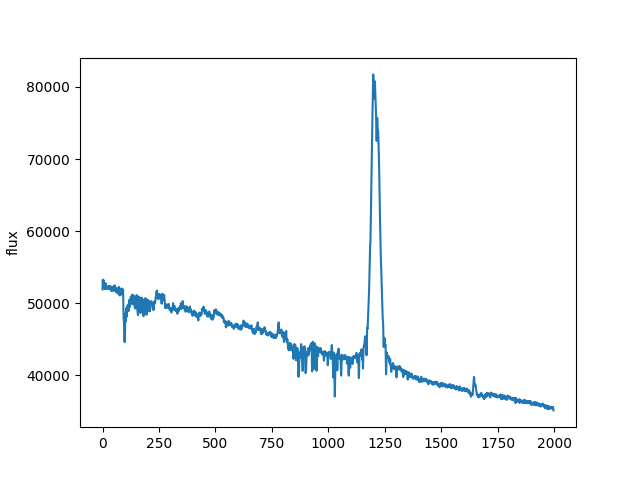

In [7]:
plt.plot(raw_flux)
plt.ylabel('flux')

In [8]:
import astropy.wcs

In [9]:
# create the WCS object from a header
raw_wcs = astropy.wcs.WCS(raw_hdulist[0].header)
# get the wavelength
# raw_header['NAXIS1'] is the number of flux points
raw_wavelen = raw_wcs.wcs_pix2world(
    range(raw_header['NAXIS1']), 0
)[0]

HISTORY1                                                                         [astropy.io.fits.card]
HISTORY2                                                                         [astropy.io.fits.card]


<IPython.core.display.Javascript object>


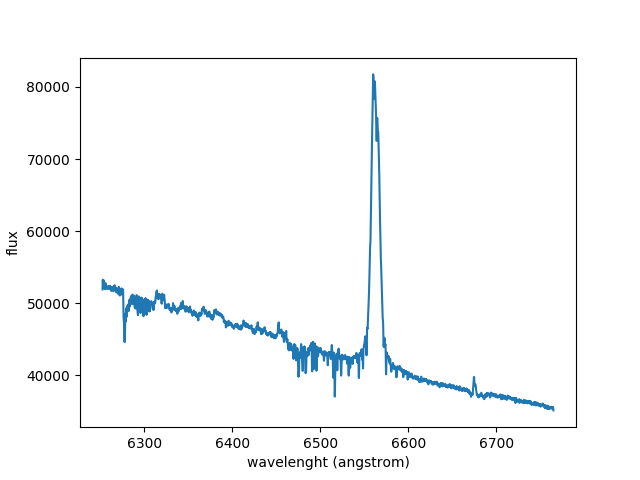

In [10]:
plt.plot(raw_wavelen, raw_flux)
plt.ylabel('flux')
plt.xlabel('wavelenght (angstrom)')

## Spetrum Normalization

In [11]:
def parse_fits_id(path):
    filename = os.path.split(path)[-1]
    identifier = os.path.splitext(filename)[0]
    return identifier

norm_fits_id = parse_fits_id(raw_fits_filename)

In [12]:
norm_fits_dir = os.path.join(
    'ondrejov-ccd700', 'normalized'
)
norm_fits_filename = os.path.join(
    norm_fits_dir, norm_fits_id + '.fit'
)
norm_hdulist = astropy.io.fits.open(norm_fits_filename)
norm_hdulist.info()

Filename: ondrejov-ccd700/normalized/uh290017.fit
No.    Name         Type      Cards   Dimensions   Format
0    PRIMARY     PrimaryHDU     142   ()              
1                BinTableHDU     19   1997R x 2C   [D, D]   


HISTORY1                                                                         [astropy.io.fits.card]
HISTORY2                                                                         [astropy.io.fits.card]


In [13]:
norm_hdulist[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                    8 / Bits per pixel                                 
NAXIS   =                    0 / Number of axes                                 
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 2003' / FITS file originator        
IRAF-TLM= '2011-09-19T20:16:19' / Time of last modification                     
OBJECT  = '59 Cyg  '           / Title of observation                           
DATE    = '2011-09-19T20:16:19' / Date FITS file was generated                  
SYSVER  = 'BIAS r151'          / Jul 31 2011 14:57:30                           
OBSERVAT= 'ONDREJOV'           / Name of observatory (IRAF style)               
LATITUDE=            49.910555 / Telescope latitude  (degrees), +49:54:38.0     
LONGITUD=            14.783611 / Telescope longitud  (degrees), +14:47:01.0     
HEIGHT  =                 05

In [14]:
norm_hdulist[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   16 / length of dimension 1                          
NAXIS2  =                 1997 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    2 / number of table fields                         
TTYPE1  = 'WAVE    '                                                            
TFORM1  = 'D       '                                                            
TUNIT1  = 'Angstrom'                                                            
TTYPE2  = 'FLUX    '                                                            
TFORM2  = 'D       '        

<IPython.core.display.Javascript object>


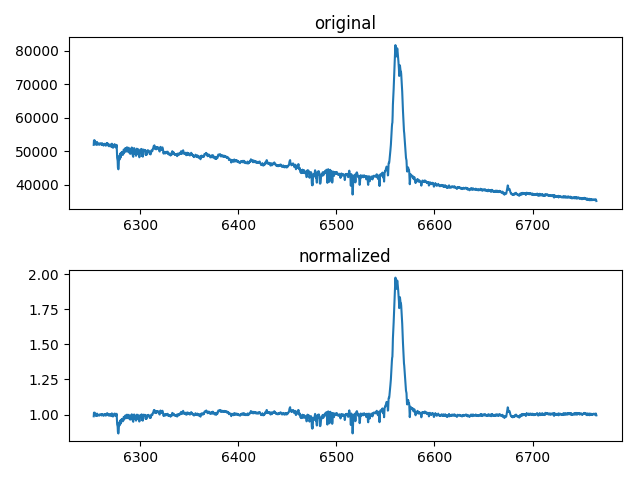

In [15]:
norm_wavelen = norm_hdulist[1].data['WAVE']
norm_flux = norm_hdulist[1].data['FLUX']
plt.subplot(2, 1, 1)
plt.title('original')
plt.plot(raw_wavelen, raw_flux)
plt.subplot(2, 1, 2)
plt.title('normalized')
plt.plot(norm_wavelen, norm_flux)
plt.tight_layout()

To make sure that the computed wavelengths and the
wavelengths from normalized data are the same the
`np.allclose` function is used. And it need to be believed
that it is true for all others.

In [16]:
import numpy as np

In [17]:
assert np.allclose(raw_wavelen, norm_wavelen) == True

## Load All Normalized Spectra

In [18]:
# get all filenames
norm_fits_filenames = glob.glob(os.path.join(
    norm_fits_dir, '*.fit'
))

In [19]:
def parse_norm_fits(filename):
    '''Parse normalized spectrum from fits file.
    Returns its id, wavelenght as np.array and
    flux as np.array. The data has to be in the
    second HDU an the flux and the wavelen need to
    be indexable be FLUX and WAVE keywords.'''
    with astropy.io.fits.open(filename) as hdulist:
        wavelen = hdulist[1].data['WAVE']
        flux = hdulist[1].data['FLUX']
    return parse_fits_id(filename), wavelen, flux

In [20]:
H_ALPHA = 6562.8

def in_range(start, stop, val=H_ALPHA):
    '''Check if val is in range [start, stop]'''
    return start <= val <= stop

def in_wavelen(wavelens, val=H_ALPHA):
    '''Check if val is somewhere in-between wavelens
    array start and end.'''
    return in_range(wavelens[0], wavelens[-1], val)

In [21]:
# the data stucture is dict where a key is spectrum id
# and a value is dict of wavelen and flux
spectra = {
    fits_id: {'wavelen': wavelen, 'norm_flux': flux}
    for fits_id, wavelen, flux in map(
        parse_norm_fits, norm_fits_filenames
    )
    if in_wavelen(wavelen, H_ALPHA)
}

HISTORY1                                                                         [astropy.io.fits.card]
HISTORY2                                                                         [astropy.io.fits.card]


In [22]:
# size of data
len(spectra)

13344

### Add Original Flux

In [23]:
def parse_raw_fits(filename):
    with astropy.io.fits.open(filename) as hdulist:
        raw_flux = hdulist[0].data
    return parse_fits_id(filename), raw_flux

for filename in raw_fits_filenames:
    try:
        fits_id, raw_flux = parse_raw_fits(filename)
    except OSError:
        continue
    try:
        spectra[fits_id]['raw_flux'] = raw_flux
    except KeyError:
        # some spectra are already filtered out
        pass

HISTORY1                                                                         [astropy.io.fits.card]
HISTORY2                                                                         [astropy.io.fits.card]
    'ascii' codec can't decode byte 0xc8 in position 753: ordinal not in range(128)
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    'ascii' codec can't decode byte 0xe1 in position 754: ordinal not in range(128)
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]
    'ascii' codec can't decode byte 0xfa in position 756: ordinal not in range(128)
There may be extra bytes after the last HDU or the file is corrupted. [astropy.io.fits.hdu.hdulist]


There are some corrupted FITS file. For example, they containg non-ASCII characters. Therefore, patience should
be when working with raw flux.

In [24]:
len(list(filter(
    lambda x: 'raw_flux' not in spectra[x],
    spectra
)))

366

### Serialize with Pickle

In [25]:
import pickle

In [26]:
# serialize the object for later use
pickle_filename = 'ondrejov-halpha.pickle'
with open(os.path.join('data', pickle_filename), 'wb') as f:
    pickle.dump(spectra, f)